In [ ]:
!nvidia-smi

Mon Jun 27 11:26:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18, resnet34
import os

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cp /content/drive/MyDrive/CUB_200_2011.tgz /content/

In [ ]:
!tar -xvxf CUB_200_2011.tgz

In [ ]:
import shutil

In [ ]:
data_dir = '/content/CUB_200_2011/'
images_dir = os.path.join(data_dir, 'images')

train_dir = os.path.join(data_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
test_dir = os.path.join(data_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

classes = os.listdir(images_dir)

with open('/content/CUB_200_2011/images.txt') as f:
  image_names = f.readlines()

with open('/content/CUB_200_2011/train_test_split.txt') as f:
  train_test_split = f.readlines()

for train_idx, image_name in zip(train_test_split, image_names):
  num, class_image_name = image_name.split()
  image_idx, train_flag = train_idx.split()
  image_path = os.path.join(images_dir, class_image_name)
  class_name = class_image_name.split('/')[0]
  train_class_dir = os.path.join(train_dir, class_name)
  os.makedirs(train_class_dir, exist_ok=True)
  test_class_dir = os.path.join(test_dir, class_name)
  os.makedirs(test_class_dir, exist_ok=True)
  if train_flag == '0':
    shutil.copy(image_path, train_class_dir)
  else:
    shutil.copy(image_path, test_class_dir)

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
      transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
    ),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
      self.transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.RandomApply([
      transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
    ),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
      self.transform2=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
        
    def __call__(self, x):
        return [self.transform(x), self.transform2(x)]

In [ ]:
class CUBDataset(Dataset):
  def __init__(self, phase):
    self.dataset = datasets.ImageFolder(root=f'/content/CUB_200_2011/{phase}/')
    self.tr = TwoCropTransform(self.dataset)
    # self.bbxs = []
  def __getitem__(self, item):
    img_tuple = self.dataset.imgs[item]
    label = img_tuple[1]
    img = self.dataset.loader(img_tuple[0])
    img1, img2 = self.tr(img)
    # item2 = torch.randint(len(self.dataset)) #khoondan az yek item dge ke be soorat random dade ro az len barmidare.
    # self.dataset.imgs[item2]
    # patch = img[self.bbxs[item][0]:self.bbxs[item][2], self.bbxs[item][1]:self.bbxs[item][3]]
    return  img1,img2,label

  def __len__(self):
    return len(self.dataset)

In [ ]:
trainset = CUBDataset(phase='train')

In [ ]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(trainloader)
img1,img2,labels = dataiter.next()

In [ ]:
img1.shape

torch.Size([100, 3, 224, 224])

In [ ]:
img2.shape

torch.Size([100, 3, 224, 224])

In [ ]:
labels.shape

torch.Size([100])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

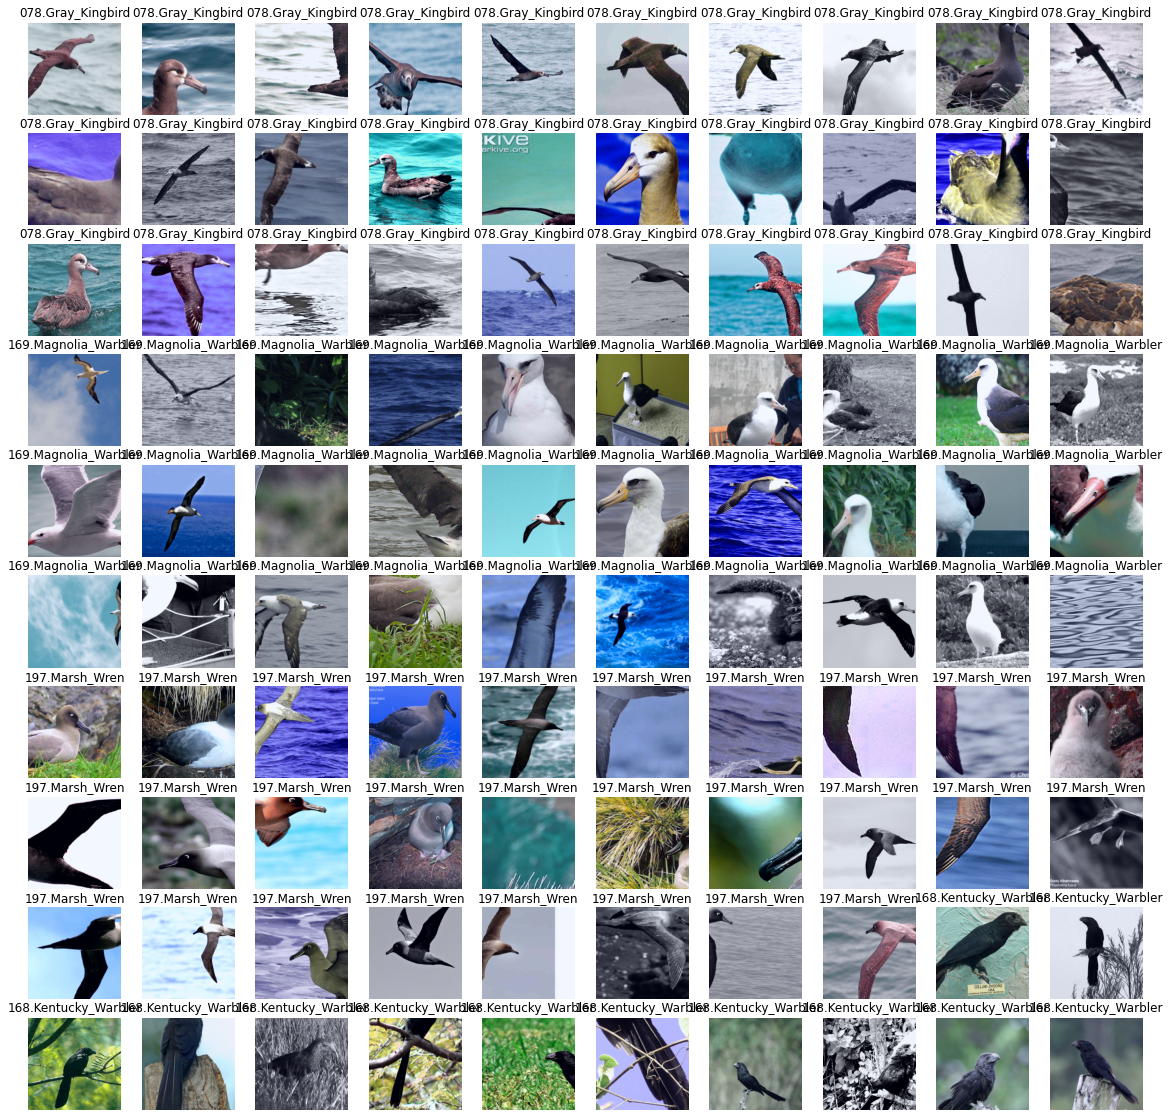

In [ ]:
plot_images(img1, labels, classes, normalize=True)

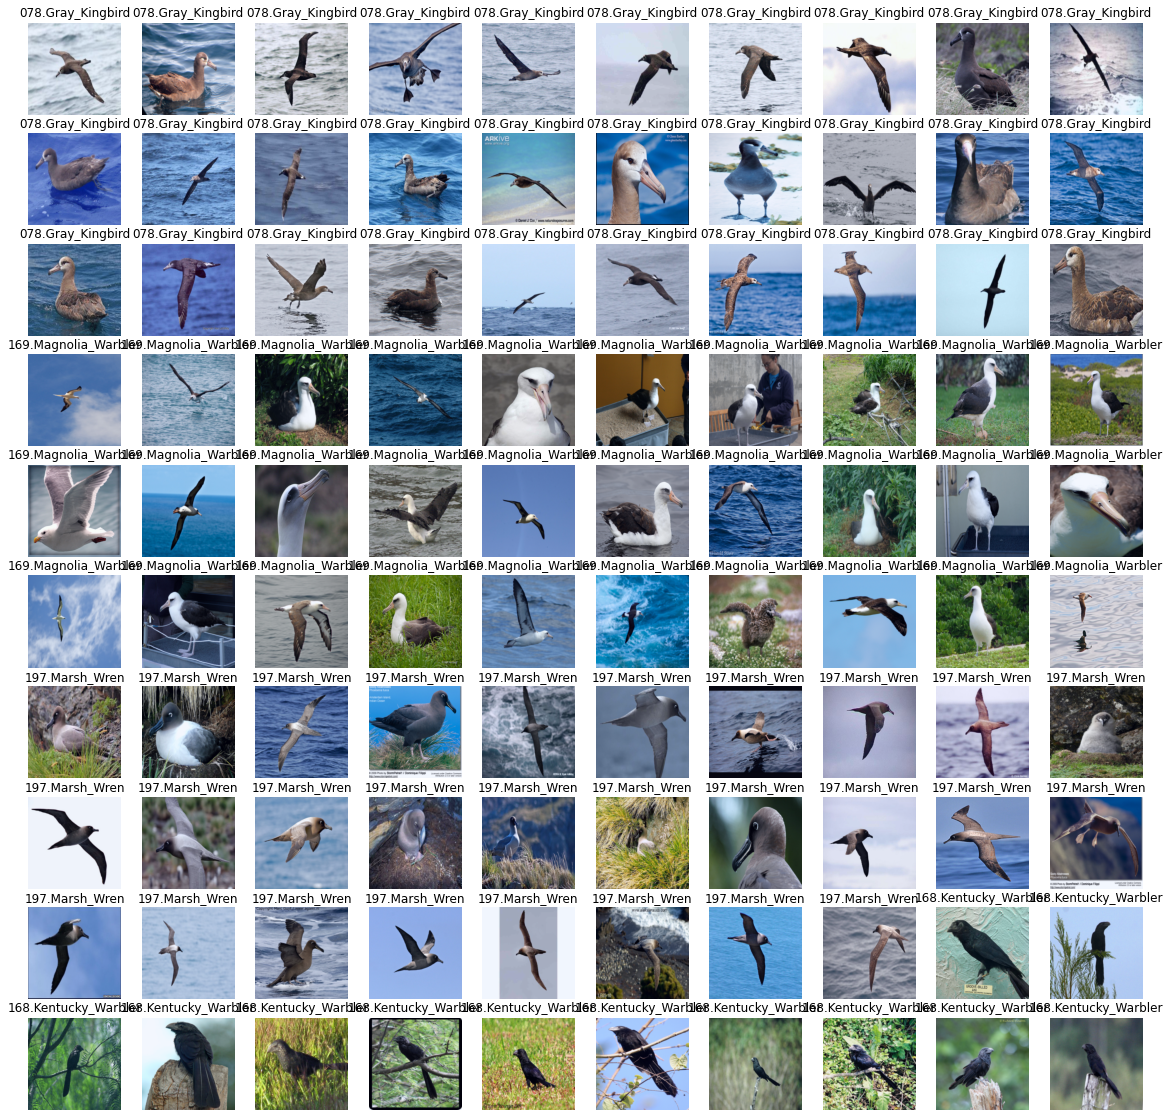

In [ ]:
plot_images(img2, labels, classes, normalize=True)